## Package imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import pymc3 as pm
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

## Data loading and preparation
* Log transformation of `tot.catch`
* Block the data to obtain train and test set

   latitude  longitude  tot.catch
1  40.55000  -71.55000          0
2  40.46667  -71.51667          0
3  40.51667  -71.71667          0
4  40.38333  -71.85000          1
5  40.31667  -71.78333          0


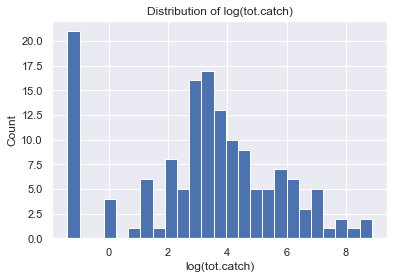

In [2]:
scallop = pd.read_csv('scallop.csv',index_col=0)
print(scallop.head())

# log transformation
data = scallop.copy()
data["tot.catch"] = np.log(data["tot.catch"]+0.25)
plt.hist(data["tot.catch"],bins=25)
plt.xlabel('log(tot.catch)')
plt.ylabel('Count')
plt.title('Distribution of log(tot.catch)')
plt.show()

In [3]:
# test set: latitude>40 & longitude>-72
test = data[(data['latitude']>40) & (data['longitude']>-72)]
train = data[~(data['latitude']>40) | ~(data['longitude']>-72)]

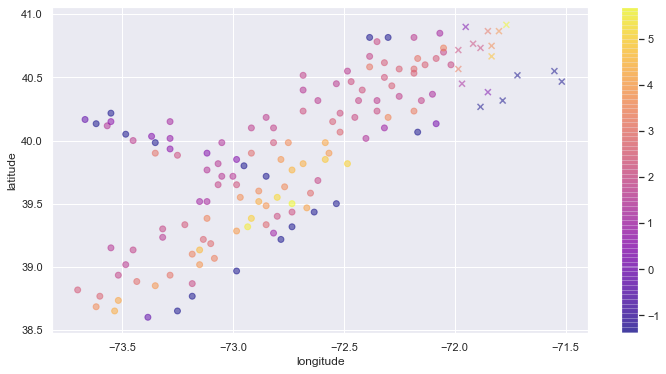

In [4]:
plt.figure(figsize=(12,6))
plt.scatter(train["longitude"], train["latitude"], alpha=0.5, c=train["tot.catch"], cmap='plasma')
plt.scatter(test["longitude"], test["latitude"], alpha=0.5, c=test["tot.catch"], cmap='plasma', marker='x')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [5]:
x_train = train[['longitude','latitude']].values
y_train = np.array(train['tot.catch'])

print(x_train.shape)
print(y_train.shape)

(131, 2)
(131,)


In [6]:
x_test = test[['longitude','latitude']].values
y_test = np.array(test['tot.catch'])

print(x_test.shape)
print(y_test.shape)

(17, 2)
(17,)


## MCMC simulation

The kernel we use is Squared Exponential (SE):
<center>$kernel\_SE = \sigma_f^2 exp(-\frac{1}{2l^2}|x_i - x_j|^2)$</center>

Parameters need to be simulated:
* $\sigma_f$: amplitude of the kernel, the scale of the output values
* $l$: length of the kernel, the scale at which distances are measured among inputs
* $\sigma_n$: noise of GP, the scale of the output noise

Prior_1:

sigma_f ~ HalfNormal(1)

l ~ InverseGamma(5,5)

sigma_n ~ HalfNormal(1)

In [14]:
print(f'{pm.__name__}: v. {pm.__version__}')
print(f'{theano.__name__}: v. {theano.__version__}')

pymc3: v. 3.9.2
theano: v. 1.0.4


In [30]:
dim = 2
n_draw = 1000
seed = 630

with pm.Model() as model_1:
    sigma_f = pm.HalfNormal("sigma_f",sigma = 1)
    l = pm.InverseGamma("l",alpha = 5, beta = 5)

    # specify the covariance function
    cov_func = sigma_f**2 * pm.gp.cov.ExpQuad(dim,ls=l) 
    
    # specify the GP with mean 0
    gp = pm.gp.Marginal(cov_func=cov_func)

    sigma_n = pm.HalfNormal("sigma_n",sigma = 1)
    
    y = gp.marginal_likelihood("y", X=x_train, y=y_train, noise=sigma_n)

    trace_1 = pm.sample(n_draw, random_seed=seed, tune=500, progressbar=True, cores=1, chains=4)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 42 seconds.
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed527b1b10>,
      dtype=object)

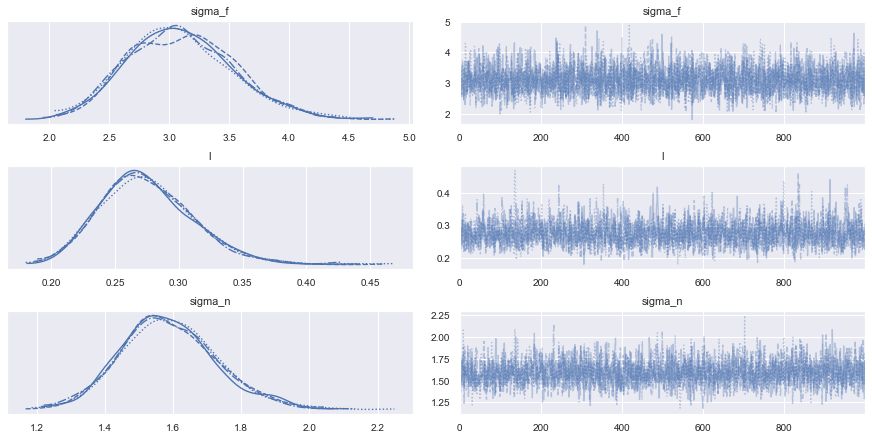

In [18]:
pm.traceplot(trace_1)

In [19]:
pm.summary(trace_1)

/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_f,3.097,0.436,2.285,3.909,0.007,0.005,3999.0,3829.0,4061.0,3005.0,1.0
l,0.276,0.036,0.208,0.339,0.001,0.001,2560.0,2497.0,2630.0,2677.0,1.0
sigma_n,1.589,0.138,1.333,1.862,0.003,0.002,2653.0,2649.0,2660.0,2346.0,1.0


## Conditional distribution on test set (computing RMSE)

In [31]:
with model_1:
    test_pred = gp.conditional('test_pred',x_test,pred_noise = True)
    test_pred_samples = pm.sample_posterior_predictive(trace_1, vars = [test_pred], samples=50)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is sm

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [32]:
map = pm.find_MAP(model = model_1)
mu,var = gp.predict(x_test, point=map, diag=True, pred_noise=True)
sd = np.sqrt(var)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [33]:
RMSE = np.sqrt(np.mean((np.exp(mu) - np.exp(y_test))**2))
RMSE

76.93838646062298

## Generate new curves

1. Visualize scallop distribution and determine how to slice 
    - holding `latitude` at [40.5, 40.6]
    - holding `longitude` at [-72.5, 72.4]

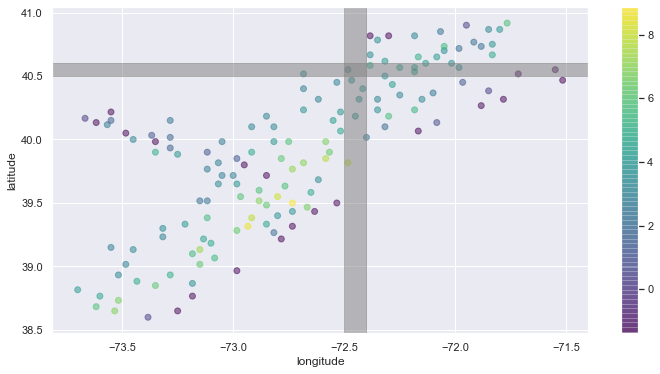

In [34]:
plt.figure(figsize=(12,6))
plt.scatter(data["longitude"], data["latitude"], alpha=0.5, c=data["tot.catch"], cmap='viridis')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

# slice latitude at [40.5,40.6]
y1 = 40.5
y2 = 40.6
plt.axhspan(y1, y2, alpha=0.5, color='#808080')

# slice longitude at [-72.5,-72.4]
x1 = -72.5
x2 = -72.4
plt.axvspan(x1, x2, alpha=0.5, color='#808080')
plt.show()

In [35]:
# extract the observed values
plot_data = data[(data['latitude']>=40.5) & (data['latitude']<=40.6)]
obs_y_1 = np.array(plot_data['tot.catch'])
obs_longi = np.array(plot_data['longitude'])

In [54]:
# generate latitude and longitude (new data)
min_longi = min(data['longitude'])
max_longi = max(data['longitude'])
x1_range = np.arange(min_longi, max_longi, 0.05)
x2_range = np.arange(y1, y2, 0.05)
x1_grid, x2_grid= np.meshgrid(x1_range, x2_range)

x_full_1 = np.c_[x1_grid.ravel(), x2_grid.ravel()]

In [55]:
# extract longitude values from new data
longi_1D = []
for i in range(len(x_full_1)):
    longi_1D.append(x_full_1[i][0])
longi_1D = np.array(longi_1D)

In [57]:
with model_1:
    pred_y_longi_1 = gp.conditional('pred_y_longi_1',x_full_1)
    pred_sample_longi_1 = pm.sample_posterior_predictive(trace_1,vars=[pred_y_longi_1],samples=50)

/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [58]:
# extract the observed values
plot_data = data[(data['longitude']>=-72.5) & (data['longitude']<=-72.4)]
obs_y_2 = np.array(plot_data['tot.catch'])
obs_lati = np.array(plot_data['latitude'])

In [59]:
# generate latitude and longitude (new data)
min_lati = min(data['latitude'])
max_lati = max(data['latitude'])
x1_range = np.arange(x1, x2, 0.05)
x2_range = np.arange(min_lati, max_lati, 0.05)
x1_grid, x2_grid= np.meshgrid(x1_range, x2_range)

x_full_2 = np.c_[x1_grid.ravel(), x2_grid.ravel()]

In [60]:
# extract latitude values from new data
lati_1D = []
for i in range(len(x_full_2)):
    lati_1D.append(x_full_2[i][1])
lati_1D = np.array(lati_1D)

In [61]:
with model_1:
    pred_y_lati_1 = gp.conditional('pred_y_lati_1',x_full_2)
    pred_sample_lati_1 = pm.sample_posterior_predictive(trace_1,vars=[pred_y_lati_1],samples=50)

In [63]:
def slice_posterior_plot(pred_sample_1, pred_sample_2, pred_y_name1, pred_y_name2, obs_x1, obs_y_1, obs_x2, obs_y_2):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
    ax1.set_xlim(min_longi,max_longi)
    
    # plot generated functions
    for c in pred_sample_1[pred_y_name1]:
        ax1.plot(longi_1D,c,'gray',alpha=0.15)

    # plot observed data
    ax1.scatter(obs_x1, obs_y_1, alpha=1, c = "b", label="observed data");

    ax1.set_xlabel('longitude')
    ax1.set_ylabel('predictive log(tot.catch)')
    ax1.set_title('posterior over function')
    ax1.legend()
    
    
    ax2.set_xlim(min_lati,max_lati)

    # plot generated functions
    for c in pred_sample_2[pred_y_name2]:
        ax2.plot(lati_1D,c,'gray',alpha=0.15)

    # plot observed data
    ax2.scatter(obs_x2, obs_y_2, alpha=1, c = "b", label="observed data");

    ax2.set_xlabel('latitude')
    ax2.set_ylabel('predictive log(tot.catch)')
    ax2.set_title('posterior over function')
    ax2.legend()
    
    plt.show()

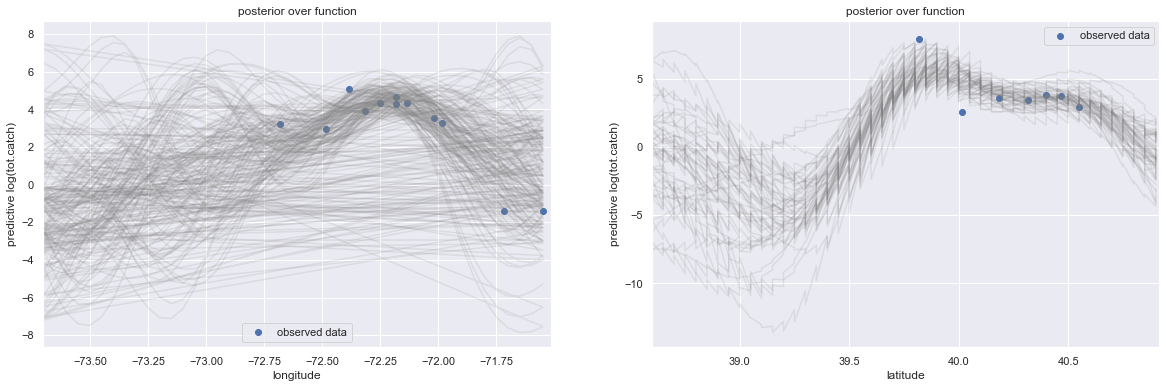

In [64]:
slice_posterior_plot(pred_sample_longi_1, pred_sample_lati_1, 
                     'pred_y_longi_1', 'pred_y_lati_1', obs_longi, obs_y_1, obs_lati, obs_y_2)

Prior_2:

sigma_f ~ HalfCauchyl(2)

l ~ HalfCauchy(2)

sigma_n ~ HalfNormal(1)

In [51]:
dim = 2
n_draw = 1000
seed = 630

with pm.Model() as model_2:
    sigma_f = pm.HalfCauchy("sigma_f",beta = 2)
    l = pm.HalfCauchy("l", beta = 2)

    # specify the covariance function
    cov_func = sigma_f**2 * pm.gp.cov.ExpQuad(dim,ls=l) 
    
    # specify the GP with mean 0
    gp = pm.gp.Marginal(cov_func=cov_func)

    sigma_n = pm.HalfNormal("sigma_n",sigma = 1)
    
    y = gp.marginal_likelihood("y", X=x_train, y=y_train, noise=sigma_n)

    trace_2 = pm.sample(n_draw, random_seed=seed, tune=500, progressbar=True, cores=1, chains=4)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.8860637075289738, but should be close to 0.8. Try to increase the number of tuning steps.


/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb70ff7bc10>,
      dtype=object)

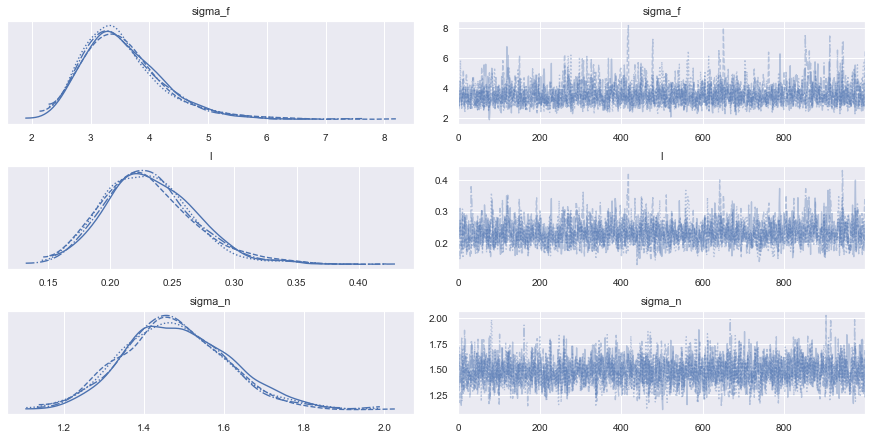

In [52]:
pm.traceplot(trace_2)

In [53]:
pm.summary(trace_2)

/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_f,3.575,0.713,2.424,4.866,0.017,0.013,1799.0,1626.0,2052.0,1564.0,1.0
l,0.232,0.037,0.164,0.296,0.001,0.001,1836.0,1800.0,1887.0,1867.0,1.0
sigma_n,1.478,0.128,1.243,1.719,0.003,0.002,2552.0,2552.0,2533.0,2785.0,1.0


In [66]:
with model_2:
    pred_y_longi_2 = gp.conditional('pred_y_longi_2',x_full_1)
    pred_sample_longi_2 = pm.sample_posterior_predictive(trace_2,vars=[pred_y_longi_2],samples=50)

In [67]:
with model_2:
    pred_y_lati_2 = gp.conditional('pred_y_lati_2',x_full_2)
    pred_sample_lati_2 = pm.sample_posterior_predictive(trace_2,vars=[pred_y_lati_2],samples=50)

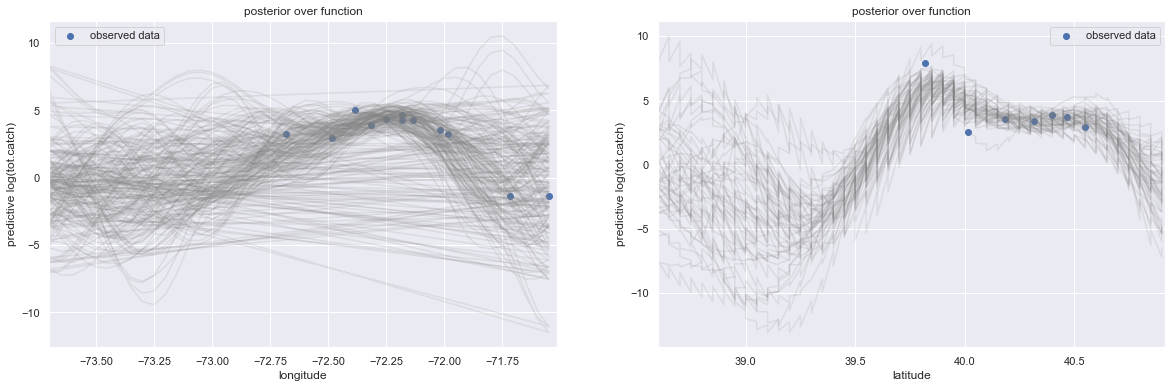

In [68]:
slice_posterior_plot(pred_sample_longi_2, pred_sample_lati_2, 
                     'pred_y_longi_2', 'pred_y_lati_2', obs_longi, obs_y_1, obs_lati, obs_y_2)